# Visualization Demo

In [1]:
import napari
%gui qt5

In [2]:
from brainlit.utils.ngl_pipeline import NeuroglancerSession
from brainlit.utils.swc import *
from brainlit.viz.visualize import *
import numpy as np
from skimage import io
from pathlib import Path

## Loading Data

In [46]:
data_dir = str(Path().resolve().parents[2] / "tests" / "upload" / "test_precomputed_serial")
swc_dir = str(Path().resolve().parents[2] / "tests" / "upload_segments")
dest_dir = str(Path().resolve().parents[0] / "utils" / "upload")
dest_dir_segments = str(Path().resolve().parents[0] / "utils" / "upload_segments")
themip = 0
sid = 2
vid = 300

In [47]:
# Create a neuroglancersession
ngl_sess = NeuroglancerSession(
    url="file://"+dest_dir, 
    url_segments="file://"+dest_dir_segments,
    mip=themip
)

In [48]:
img, bbbox, vox = ngl_sess.pull_voxel(sid, vid, 1, 1, 1)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


In [49]:
skel = ngl_sess.cv_segments.skeleton.get(sid)
vertex = skel.vertices[vid]/ngl_sess.cv_segments.scales[themip]["resolution"]
print(vertex)

[475.66987448 153.47237193 201.46043063]


In [50]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(np.array(img)))
viewer.add_points(data=np.array(vertex), edge_width=5, edge_color='green', name='vertex')

ValueError: Images of type float must be between -1 and 1.

## 2D Visualization

In [39]:
plot_image_2d(img[:,100,:])

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x151254828>)

Text(0.5, 1.0, 'Third Dimension')

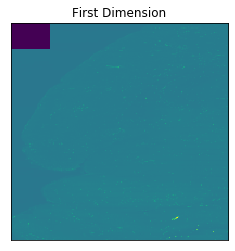

In [40]:
fig1, axes = plot_image_2d(img[50,:,:])
axes.set_title('First Dimension')

fig2, axes = plot_image_2d(img[:,50,:])
axes.set_title('Second Dimension')
    
fig3, axes = plot_image_2d(img[:,:,50])
axes.set_title('Third Dimension')

## Max intensity projection

In [41]:
fig, axis = plot_image_mip(img)
print(type(fig))

<class 'matplotlib.figure.Figure'>


## Histogram Plot of Image Intensities

In [42]:
fig = plot_image_hist(img)

## Visualizing all successors or predecessors of a given vertex up to a given depth

In [43]:
# s3_path = "s3://mouse-light-viz/precomputed_volumes/brain1_segments"
s3_path = "file://"+dest_dir_segments
seg_id = 2
df = read_s3(s3_path, seg_id, mip=themip)
df.head()

sample  structure      x      y      z    r  parent
0       1          0  295.0  279.0  241.0  1.0      -1
1       4        192  295.0  277.0  240.0  1.0       1
2       7         64  295.0  277.0  241.0  1.0       4
3       8          0  296.0  278.0  241.0  1.0       7
4      14          0  297.0  277.0  241.0  1.0       8

In [44]:
G = df_to_graph(df)
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('\n')
print('Sample 1 coordinates (x,y,z)')
print(G.nodes[1]['x'],G.nodes[1]['y'],G.nodes[1]['z'])

paths = graph_to_paths(G=G)
print(f"The graph was decomposed into {len(paths)} paths")

Number of nodes: 1650
Number of edges: 1649


Sample 1 coordinates (x,y,z)
295 279 241
The graph was decomposed into 179 paths


In [45]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(np.array(img)))
# viewer.add_points(data=np.concatenate(paths, axis=0)[1024:], edge_width=2, edge_color='white', name='all_points')
viewer.add_shapes(data=paths, shape_type='path', edge_color='white', edge_width=3, name='skeleton')
viewer.add_points(data=np.array(vertex), edge_width=5, edge_color='green', name='vertex')

<Points layer 'vertex' at 0x1465837f0>

In [14]:
v_id = 44  # the row index/number of the data frame
depth = 30  # the depth up to which the graph must be constructed

G_bfs=get_bfs_subgraph(G, v_id, depth, df=df)  # perform Breadth first search to obtain a graph of interest
paths_bfs = graph_to_paths(G=G_bfs[0])  # obtain all the paths for visualization purposes

In [15]:
x = df.iloc[v_id]['x']
y = df.iloc[v_id]['y']
z = df.iloc[v_id]['z']
v_pos = np.array([x,y,z])

# display vertex
viewer = napari.Viewer(ndisplay=3)
viewer.add_points(data=v_pos, edge_width=20, edge_color='orange', name='vertex')

# display all interest nodes around vertex
viewer.add_points(data=np.concatenate(paths_bfs), edge_color='red', edge_width=2, name='subpoints')
viewer.add_shapes(data=paths_bfs, shape_type='path', edge_color='red', edge_width=3, name='sub-skeleton')

<Shapes layer 'sub-skeleton' at 0x14f39c7b8>